# Toilet Reference Recognition with CNN

### Toilet Reference - using CNN with Transfer Learning
Tomado de Kaggle https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

# Load packages

In [1]:
import cv2, random
import os, shutil
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical

source_dir = "E:\\OneDrive - Corona\\03_Proy_ID\\03_MACHINE_LEARNING\\01_Projects\\04_VA_Ref_Esmaltado\\04_Genie_Nano\\01_IA\\XX_Datos_Celula4"
print(os.listdir(source_dir))


['Augmentation_Temp', 'Errors', 'Nueva_Referencia', 'Reentrenar', 'Test', 'Train']


In [2]:
import tensorflow as tf

print("TensorFlow_Version: ", tf.__version__)
print("Physical Device: ", tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow_Version:  2.13.0
Physical Device:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0


# Parameters
Here we set fews parameters used in the model:
- The original image size is 1800 x 1600 
- The images will be resized to 360 x 320 
- The images are stored in two folders, train and test.
- There are 13 image classes: 2010, 2025, 2782, 2920, 2921, 2930, 3000,  3918, 4115, 4810, 9147, 9311, Empty and Sin Tapa
- A number of 50 epochs will be used for training.

## Define Constants

In [3]:
FAST_RUN = False
IMAGE_WIDTH = 360
IMAGE_HEIGHT = 320
IMAGE_SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)
IMAGE_CHANNELS = 1

# Prepare Traning Data

In [4]:
# Directorios de trabajo
train_dir = os.path.join(source_dir, 'Train')
#val_dir = os.path.join(source_dir, 'Valid')
test_dir = os.path.join(source_dir, 'Test')
error_dir = os.path.join(source_dir, 'Errors')


print(os.listdir(train_dir))

['2010', '2025', '2782', '2920', '2921', '2930', '3000', '3918', '4115', '4810', '9147', '9311', 'Empty', 'Sin_Tapa']


In [5]:
# DF Initialitation
df = pd.DataFrame(columns=["Filename", "Reference", "Category"])
filename = []
reference = []
category = []

for cont, folder in enumerate(os.listdir(train_dir)):
    filenames_ref = os.listdir(train_dir + "\\" + folder)
    
    filename += filenames_ref
    reference += [folder] * len(filenames_ref)
    category += [cont] * len(filenames_ref)
    
    
df["Filename"] = filename
df["Reference"] = reference
df["Category"] = category

    
df.head()

,Filename,Reference,Category
0,test_Genie_2010_1690624405.png,2010,0
1,test_Genie_2010_1690624422.png,2010,0
2,test_Genie_2010_1690624615.png,2010,0
3,test_Genie_2010_1690624634.png,2010,0
4,test_Genie_2010_1690624729.png,2010,0


<Axes: xlabel='Reference'>

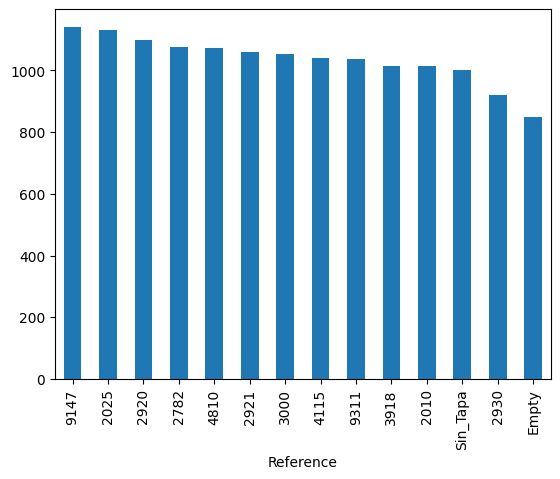

In [6]:
# Relación de categorias
df['Reference'].value_counts().plot.bar()

## Plotting some random image

In [7]:
sample = random.choice(df["Filename"])
folder = df[df["Filename"] == sample]["Reference"]

print(sample)
print(folder.item())

test_Genie_1688990625.png
4115


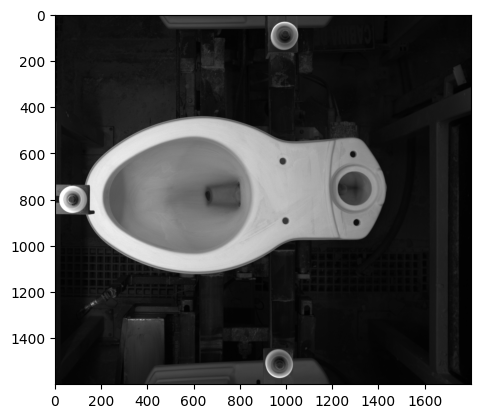

In [8]:
image = load_img(train_dir + "\\" + folder.item() + "\\" + sample)
    
plt.imshow(image)

# Build Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(14, activation='softmax')) # 14 because we have 14 classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 358, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 318, 358, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 159, 179, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 177, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 157, 177, 64)      256       
 chNormalization)                                                
                                                        

## Callbacks

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

# TensorBoard
log_dir=".\\logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0)

# Early Stop - To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
earlystop = EarlyStopping(monitor='val_accuracy', patience=10)

# Learning Rate Reduction - We will reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00001)

#callbacks = [tensorboard, earlystop, learning_rate_reduction]
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

## Traning Generator

In [11]:
batch_size=20

train_datagen = ImageDataGenerator(
    #rotation_range=20,
    rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    # Valildation split
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to WxL
        target_size = (IMAGE_HEIGHT,IMAGE_WIDTH),
        color_mode = 'grayscale', #Make the pictures B&W
        batch_size = batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='training'
        #save_to_dir=des_path, save_prefix="image", save_format="jpg"
        )

Found 13070 images belonging to 14 classes.


## Validation Generator

In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.10)

validation_generator = validation_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to WxL
        target_size = (IMAGE_HEIGHT,IMAGE_WIDTH),
        color_mode = 'grayscale', #Make the pictures B&W
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='validation')


Found 1446 images belonging to 14 classes.


## See how our generator work

In [13]:
temp_dir = "E:\\OneDrive - Corona\\03_Proy_ID\\03_MACHINE_LEARNING\\01_Projects\\04_VA_Ref_Esmaltado\\04_Genie_Nano\\01_IA\\XX_Datos_Celula4\\Augmentation_Temp"

example_generator = train_datagen.flow_from_directory(
        temp_dir, 
        # All images will be resized to WxL
        target_size = (IMAGE_HEIGHT,IMAGE_WIDTH),
        color_mode = 'grayscale', #Make the pictures B&W
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical'
)

Found 6 images belonging to 1 classes.


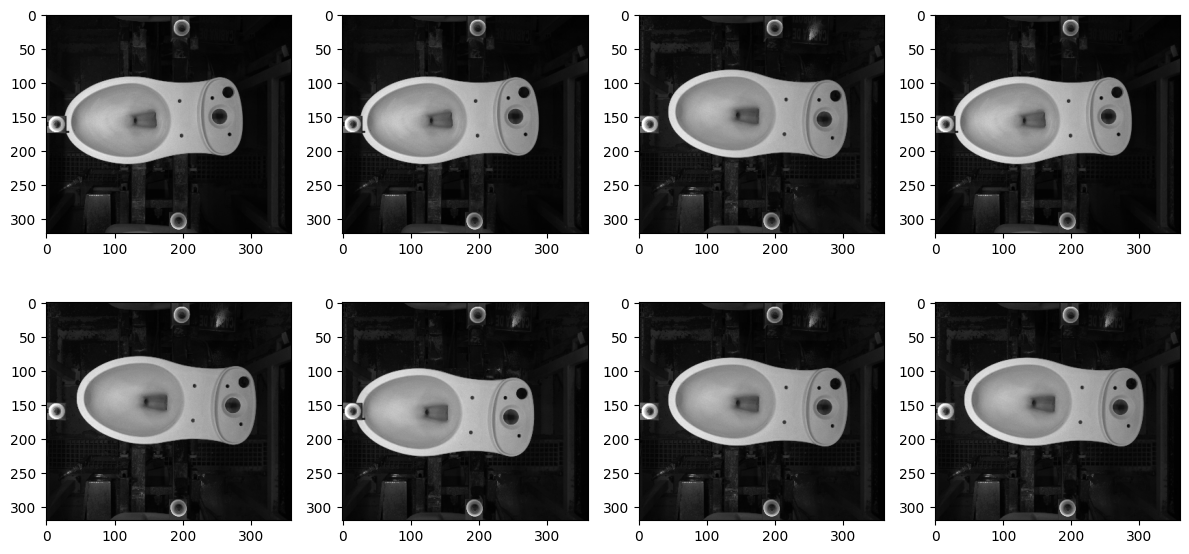

In [14]:
plt.figure(figsize=(12, 6))
for i in range(0, 8):
    plt.subplot(2, 4, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(gray_image)
        break
plt.tight_layout()
plt.show()

In [15]:
image.shape

(320, 360, 1)

# Fit Model

In [ ]:
FAST_RUN = False

epochs=5 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    steps_per_epoch = 13070 //batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = 1446 //batch_size,
    callbacks = callbacks)

Epoch 1/50
653/653 [==============================] - 1263s 2s/step - loss: 0.1180 - accuracy: 0.9667 - val_loss: 0.3472 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 2/50
653/653 [==============================] - 1260s 2s/step - loss: 0.0138 - accuracy: 0.9962 - val_loss: 0.3242 - val_accuracy: 0.9319 - lr: 0.0010
Epoch 3/50
653/653 [==============================] - 1244s 2s/step - loss: 0.0092 - accuracy: 0.9975 - val_loss: 0.0136 - val_accuracy: 0.9965 - lr: 0.0010
Epoch 4/50
653/653 [==============================] - 1242s 2s/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.0842 - val_accuracy: 0.9715 - lr: 0.0010
Epoch 5/50
653/653 [==============================] - 1265s 2s/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.1489 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 6/50
653/653 [==============================] - 1244s 2s/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.6945 - val_accuracy: 0.8868 - lr: 0.0010
Epoch 7/50
653/653 [==============================] - 1246

# Visualize Model

In [41]:
# Launch Tensor flow
#%tensorboard --logdir=./logs2

# Learning curves

Let’s take a look at the learning curves of the training and validation accuracy and loss.

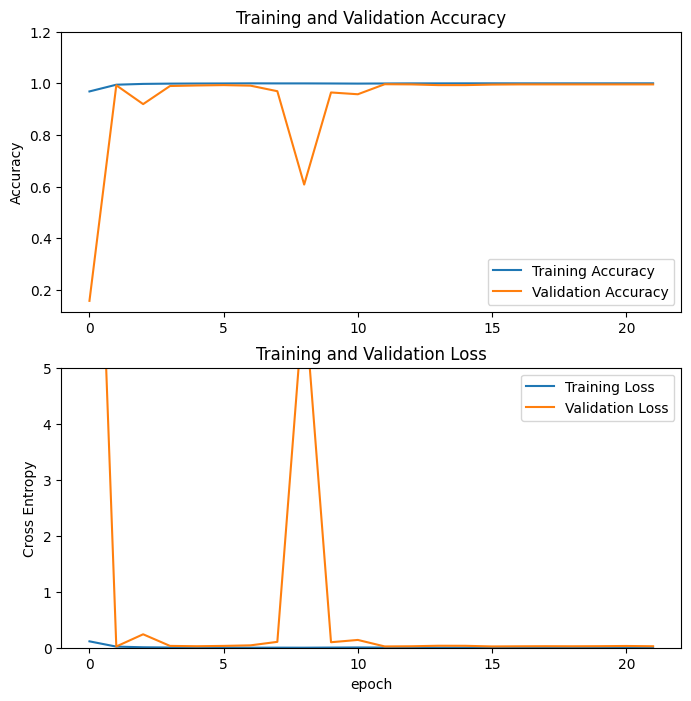

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.2])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Saving the model

In [18]:
# model.save(".\\MODEL\\Model_14Ref_Esmaltado_GR_V1.keras")

# Loading the model saved

In [19]:
from keras.models import load_model

# model2 = load_model('.\\MODEL\\Model_13Ref_Esmaltado_GR_V3.keras')
model2 = load_model('.\\MODEL\\Model_14Ref_Esmaltado_GR_V1.keras')

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 358, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 318, 358, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 159, 179, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 177, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 157, 177, 64)      256       
 chNormalization)                                                
                                                        

## Results Report

### Train_low generator

In [20]:
batch_size=20

train_datagen = ImageDataGenerator(
    #rotation_range=20,
    rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    # Valildation split
    #validation_split=0.30
)

train_generator2 = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to WxL
        target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
        color_mode = 'grayscale', #Make the pictures B&W
        batch_size = batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='training',
        shuffle=False
        #save_to_dir=des_path, save_prefix="image", save_format="jpg"
        )

Found 14507 images belonging to 14 classes.


### Prediction_Calculation

In [21]:
# import classification_report
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
# get the ground truth of your data. 
train_labels = train_generator2.class_indices.items()

In [23]:
train_labels

dict_items([('2010', 0), ('2025', 1), ('2782', 2), ('2920', 3), ('2921', 4), ('2930', 5), ('3000', 6), ('3918', 7), ('4115', 8), ('4810', 9), ('9147', 10), ('9311', 11), ('Empty', 12), ('Sin_Tapa', 13)])

In [24]:
train_generator2.classes

array([ 0,  0,  0, ..., 13, 13, 13])

In [25]:
# predict the probability distribution of the data
predictions= model2.predict(train_generator2, steps=np.ceil(14507/batch_size))

726/726 [==============================] - 500s 688ms/step


In [26]:
# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)
y_pred

array([ 0,  0,  0, ..., 13, 13, 13], dtype=int64)

### Confusion Matrix

In [27]:
y_true = train_generator2.classes
target_names = ['2010', '2025', '2782', '2920', '2921', '2930', '3000', '3918', '4115', '4810', '9147', '9311', "Empty", 'Sin_Tapa']
confusion_matrix(y_true, y_pred)

array([[1013,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0, 1132,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0, 1076,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0, 1099,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0, 1057,    0,    0,    2,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,  922,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1055,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 1007,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1041,    0,    0,
           0,    0,    0],
       [   2,    0,    0,    0,    0,    0,    0,    0,    0, 1070,    0,
           0,    

In [28]:
y_pred_label =  np.where(y_pred ==  0, '2010', y_pred)
y_pred_label =  np.where(y_pred_label ==  "1", '2025', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "2", '2782', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "3", '2920', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "4", '2921', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "5", '2930', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "6", '3000', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "7", '3918', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "8", '4115', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "9", '4810', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "10", '9147', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "11", '9311', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "12", 'Empty', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "13", 'Sin_Tapa', y_pred_label)

In [29]:
y_true_label =  np.where(y_true ==  0, '2010', y_true)
y_true_label =  np.where(y_true_label ==  "1", '2025', y_true_label)
y_true_label =  np.where(y_true_label ==  "2", '2782', y_true_label)
y_true_label =  np.where(y_true_label ==  "3", '2920', y_true_label)
y_true_label =  np.where(y_true_label ==  "4", '2921', y_true_label)
y_true_label =  np.where(y_true_label ==  "5", '2930', y_true_label)
y_true_label =  np.where(y_true_label ==  "6", '3000', y_true_label)
y_true_label =  np.where(y_true_label ==  "7", '3918', y_true_label)
y_true_label =  np.where(y_true_label ==  "8", '4115', y_true_label)
y_true_label =  np.where(y_true_label ==  "9", '4810', y_true_label)
y_true_label =  np.where(y_true_label ==  "10", '9147', y_true_label)
y_true_label =  np.where(y_true_label ==  "11", '9311', y_true_label)
y_true_label =  np.where(y_true_label ==  "12", 'Empty', y_true_label)
y_true_label =  np.where(y_true_label ==  "13", 'Sin_Tapa', y_true_label)

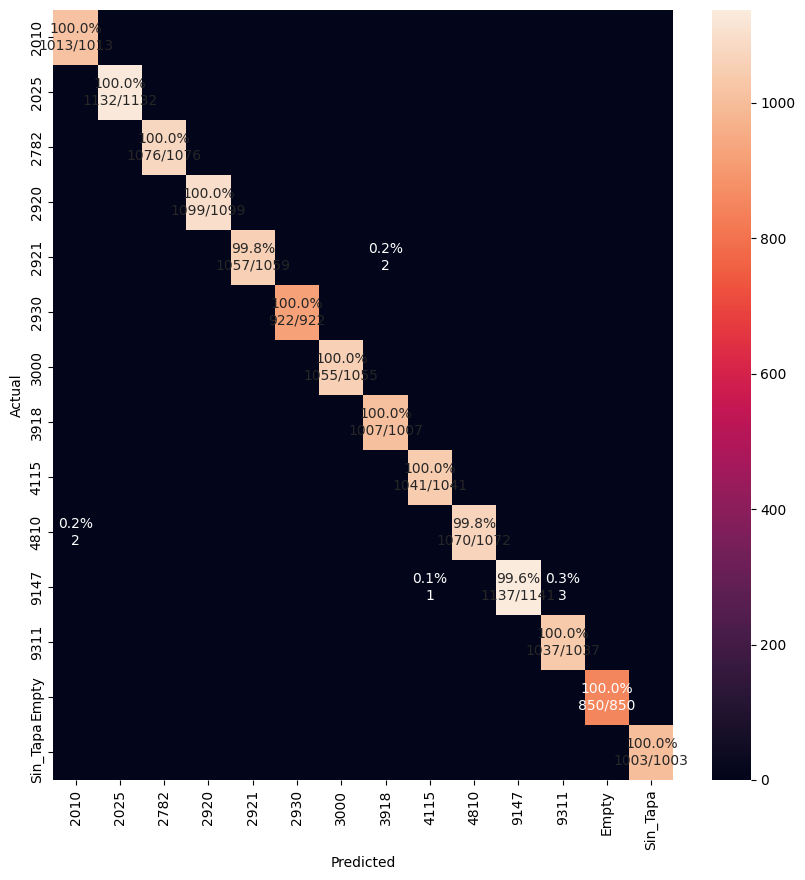

In [30]:
from Plot_confusion_matrix import cm_analysis

cm_analysis(y_true_label, y_pred_label, "confusion_matrix", target_names)

### Classification_report

In [31]:
# get the ground truth of your data. 
train_labels = train_generator2.class_indices.items()
train_labels

dict_items([('2010', 0), ('2025', 1), ('2782', 2), ('2920', 3), ('2921', 4), ('2930', 5), ('3000', 6), ('3918', 7), ('4115', 8), ('4810', 9), ('9147', 10), ('9311', 11), ('Empty', 12), ('Sin_Tapa', 13)])

In [32]:
# get the classification report
y_true = train_generator2.classes
target_names = ['2010', '2025', '2782', '2920', '2921', '2930', '3000', '3918', '4115', '4810', '9147', '9311', "Empty", 'Sin_Tapa']
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

        2010       1.00      1.00      1.00      1013
        2025       1.00      1.00      1.00      1132
        2782       1.00      1.00      1.00      1076
        2920       1.00      1.00      1.00      1099
        2921       1.00      1.00      1.00      1059
        2930       1.00      1.00      1.00       922
        3000       1.00      1.00      1.00      1055
        3918       1.00      1.00      1.00      1007
        4115       1.00      1.00      1.00      1041
        4810       1.00      1.00      1.00      1072
        9147       1.00      1.00      1.00      1141
        9311       1.00      1.00      1.00      1037
       Empty       1.00      1.00      1.00       850
    Sin_Tapa       1.00      1.00      1.00      1003

    accuracy                           1.00     14507
   macro avg       1.00      1.00      1.00     14507
weighted avg       1.00      1.00      1.00     14507



## Create Testing Generator

In [33]:
test_dir = os.path.join(source_dir, 'Test')

In [34]:
batch_size=20

test_gen = ImageDataGenerator(
    #rotation_range=20,
    rescale=1./255,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    # Valildation split
    #validation_split=0.30
)

test_generator = test_gen.flow_from_directory(
        # This is the target directory
        test_dir,
        # All images will be resized to WxL
        target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
        color_mode = 'grayscale', #Make the pictures B&W
        batch_size = batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='training',
        shuffle=False
        #save_to_dir=des_path, save_prefix="image", save_format="jpg"
        )

Found 20328 images belonging to 14 classes.


### Prediction_Calculation

In [35]:
# import classification_report
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
# get the ground truth of your data. 
test_labels = test_generator.class_indices.items()

In [37]:
test_labels

dict_items([('2010', 0), ('2025', 1), ('2782', 2), ('2920', 3), ('2921', 4), ('2930', 5), ('3000', 6), ('3918', 7), ('4115', 8), ('4810', 9), ('9147', 10), ('9311', 11), ('Empty', 12), ('Sin_Tapa', 13)])

In [38]:
test_generator.classes

array([ 0,  0,  0, ..., 13, 13, 13])

In [39]:
# predict the probability distribution of the data
predictions= model2.predict(test_generator, steps=np.ceil(20328/batch_size))

1017/1017 [==============================] - 670s 658ms/step


In [40]:
# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=-1)
y_pred

array([ 0,  0,  0, ..., 13, 13, 13], dtype=int64)

### Confusion Matrix

In [41]:
y_true = test_generator.classes
target_names = ['2010', '2025', '2782', '2920', '2921', '2930', '3000', '3918', '4115', '4810', '9147', '9311', "Empty", 'Sin_Tapa']
confusion_matrix(y_true, y_pred)

array([[ 233,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0, 2115,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0, 2026,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0, 2430,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    1,    0, 2047,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    2,    0,  441,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 2759,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,    1,    0, 2004,    0,    0,    0,
           9,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 2271,    0,    0,
           0,    0,    0],
       [   4,    0,    0,    1,    0,    0,    1,    0,    0,  939,    0,
           0,    

In [42]:
y_pred_label =  np.where(y_pred ==  0, '2010', y_pred)
y_pred_label =  np.where(y_pred_label ==  "1", '2025', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "2", '2782', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "3", '2920', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "4", '2921', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "5", '2930', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "6", '3000', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "7", '3918', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "8", '4115', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "9", '4810', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "10", '9147', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "11", '9311', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "12", 'Empty', y_pred_label)
y_pred_label =  np.where(y_pred_label ==  "13", 'Sin_Tapa', y_pred_label)

In [43]:
y_true_label =  np.where(y_true ==  0, '2010', y_true)
y_true_label =  np.where(y_true_label ==  "1", '2025', y_true_label)
y_true_label =  np.where(y_true_label ==  "2", '2782', y_true_label)
y_true_label =  np.where(y_true_label ==  "3", '2920', y_true_label)
y_true_label =  np.where(y_true_label ==  "4", '2921', y_true_label)
y_true_label =  np.where(y_true_label ==  "5", '2930', y_true_label)
y_true_label =  np.where(y_true_label ==  "6", '3000', y_true_label)
y_true_label =  np.where(y_true_label ==  "7", '3918', y_true_label)
y_true_label =  np.where(y_true_label ==  "8", '4115', y_true_label)
y_true_label =  np.where(y_true_label ==  "9", '4810', y_true_label)
y_true_label =  np.where(y_true_label ==  "10", '9147', y_true_label)
y_true_label =  np.where(y_true_label ==  "11", '9311', y_true_label)
y_true_label =  np.where(y_true_label ==  "12", 'Empty', y_true_label)
y_true_label =  np.where(y_true_label ==  "13", 'Sin_Tapa', y_true_label)

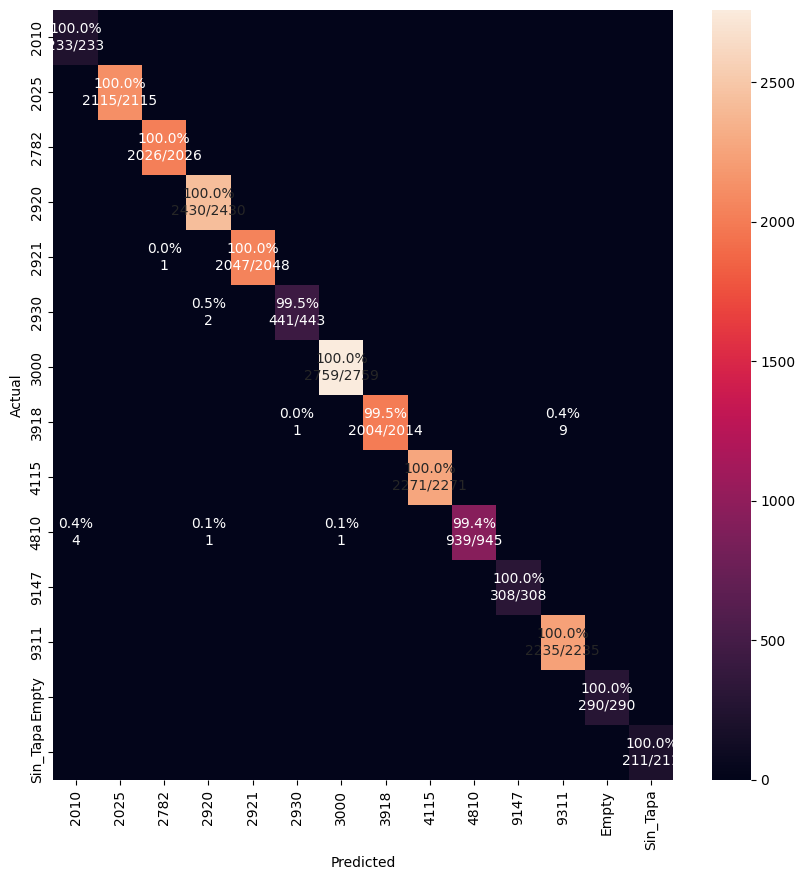

In [44]:
from Plot_confusion_matrix import cm_analysis

cm_analysis(y_true_label, y_pred_label, "confusion_matrix", target_names)

### Classification_report

In [45]:
# get the ground truth of your data. 
train_labels = test_generator.class_indices.items()
train_labels

dict_items([('2010', 0), ('2025', 1), ('2782', 2), ('2920', 3), ('2921', 4), ('2930', 5), ('3000', 6), ('3918', 7), ('4115', 8), ('4810', 9), ('9147', 10), ('9311', 11), ('Empty', 12), ('Sin_Tapa', 13)])

In [46]:
# get the classification report
y_true = test_generator.classes
target_names = ['2010', '2025', '2782', '2920', '2921', '2930', '3000', '3918', '4115', '4810', '9147', '9311', "Empty", 'Sin_Tapa']
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

        2010       0.98      1.00      0.99       233
        2025       1.00      1.00      1.00      2115
        2782       1.00      1.00      1.00      2026
        2920       1.00      1.00      1.00      2430
        2921       1.00      1.00      1.00      2048
        2930       1.00      1.00      1.00       443
        3000       1.00      1.00      1.00      2759
        3918       1.00      1.00      1.00      2014
        4115       1.00      1.00      1.00      2271
        4810       1.00      0.99      1.00       945
        9147       1.00      1.00      1.00       308
        9311       1.00      1.00      1.00      2235
       Empty       1.00      1.00      1.00       290
    Sin_Tapa       1.00      1.00      1.00       211

    accuracy                           1.00     20328
   macro avg       1.00      1.00      1.00     20328
weighted avg       1.00      1.00      1.00     20328



## Predicting a single image

### Loading the image

In [48]:
image_path = os.path.join(error_dir, '4810 (3).png')
#image_path = "E:\\OneDrive - Corona\\03_Proy_ID\\03_MACHINE_LEARNING\\01_Projects\\04_VA_Ref_Esmaltado\\04_Genie_Nano\\01_IA\\XX_Datos_Celula4\\Errors\\test_Genie_1689294465.png"

image1 = load_img(image_path, color_mode="grayscale", target_size=(320, 360))

In [49]:
type(image1)

PIL.Image.Image

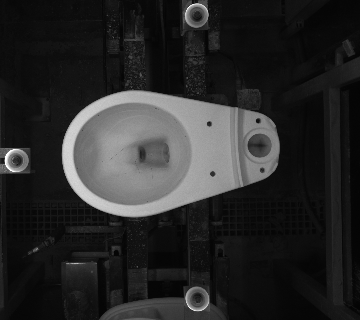

In [50]:
image1

### Transforming the image

In [51]:
# convert the image pixels to  array
input_arr = img_to_array(image1)

In [52]:
type(input_arr)

numpy.ndarray

In [53]:
input_arr.shape

(320, 360, 1)

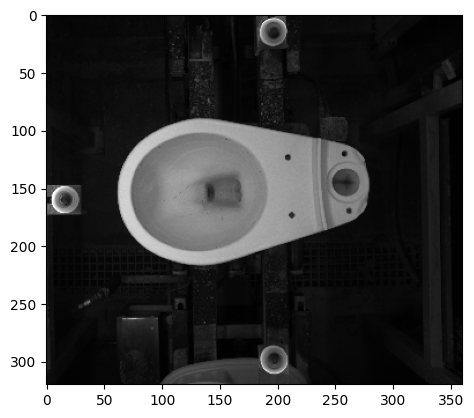

In [54]:
plt.imshow(input_arr, cmap='gray')

In [55]:
#Rescale
input_arr = input_arr/255

# Convert single image to a batch.
input_arr = np.array([input_arr])

### Predicting the image

In [56]:
# predict the probability across all output classes
prediction_classes = model2.predict(input_arr)
prediction_classes

1/1 [==============================] - 0s 197ms/step


array([[4.9301845e-05, 1.6893442e-10, 2.5399482e-05, 3.7298925e-08,
        2.4315586e-08, 6.3164356e-11, 5.1065213e-05, 1.4729256e-12,
        2.5700079e-11, 9.9987423e-01, 6.3154184e-09, 5.9473476e-12,
        3.8479104e-08, 4.0369526e-09]], dtype=float32)

In [57]:
# Take the max value of that probability
np.argmax(prediction_classes, axis=-1)

array([9], dtype=int64)

In [58]:
# Probability of prediction
prediction_classes[0][np.argmax(prediction_classes, axis=-1)[0]]

0.99987423

### Getting the label

In [59]:
ref_dict = { 0:"2010", 1:"2025", 2:"2782", 3:"2920", 4:"2921", 5:"2930", 6:'3000', 7:"3918", 8:"4115", 9:'4810', 10:'9147', 11:"9311", 12:"Empty", 13:'Sin_Tapa'}

In [60]:
ref_dict[np.argmax(prediction_classes)]

'4810'

# Testing the model

In [85]:
from keras.models import load_model

# model_test = load_model('.\\MODEL\\Model_13Ref_Esmaltado_GR_V2.keras')
model_test = load_model('.\\MODEL\\Model_14Ref_Esmaltado_GR_V1.keras')
model_test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 358, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 318, 358, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 159, 179, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 177, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 157, 177, 64)      256       
 chNormalization)                                                
                                                        

## Create Testing Generator

In [87]:
test_filenames = os.listdir(error_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [88]:
test_df.head(10)

,filename
0,test_Genie_2921_1700626454.png
1,test_Genie_2921_1700931009.png
2,test_Genie_3918_1690474565.png
3,test_Genie_3918_1690474582.png
4,test_Genie_3918_1690474587.png
5,test_Genie_3918_1690475928.png
6,test_Genie_3918_1690475945.png
7,test_Genie_3918_1690475949.png
8,test_Genie_3918_1690476007.png
9,test_Genie_3918_1690476025.png


In [89]:
batch_size=1
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    error_dir, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    color_mode = 'grayscale', #Make the pictures B&W
    #classes =['0', '1', "2", "3", "4", "5"],
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 2014 validated image filenames.


## Predict

In [90]:
predict = model_test.predict(test_generator, steps=np.ceil(2014/batch_size))
test_df['category'] = np.argmax(predict, axis=-1)
test_df['probability'] = predict[0][np.argmax(predict, axis=-1)[0]]                            
test_df.head(5)

2014/2014 [==============================] - 120s 59ms/step


,filename,category,probability
0,test_Genie_2921_1700626454.png,7,0.999986
1,test_Genie_2921_1700931009.png,7,0.999986
2,test_Genie_3918_1690474565.png,7,0.999986
3,test_Genie_3918_1690474582.png,7,0.999986
4,test_Genie_3918_1690474587.png,7,0.999986


In [91]:
#label_map = dict((v,k) for k,v in train_generator.class_indices.items())
#test_df['category'] = test_df['category'].replace(label_map)
#test_df.head(5)

In [92]:
test_df['category'] = test_df['category'].replace({ 0:"2010", 1:"2025", 2:"2782", 3:"2920", 4:"2921", 5:"2930", 6:'3000', 7:"3918", 8:"4115", 9:'4810', 10:'9147', 11:"9311", 12:"Empty", 13:'Sin_Tapa'})
test_df.head(12)

,filename,category,probability
0,test_Genie_2921_1700626454.png,3918,0.999986
1,test_Genie_2921_1700931009.png,3918,0.999986
2,test_Genie_3918_1690474565.png,3918,0.999986
3,test_Genie_3918_1690474582.png,3918,0.999986
4,test_Genie_3918_1690474587.png,3918,0.999986
5,test_Genie_3918_1690475928.png,3918,0.999986
6,test_Genie_3918_1690475945.png,3918,0.999986
7,test_Genie_3918_1690475949.png,3918,0.999986
8,test_Genie_3918_1690476007.png,3918,0.999986
9,test_Genie_3918_1690476025.png,3918,0.999986


<Axes: xlabel='category'>

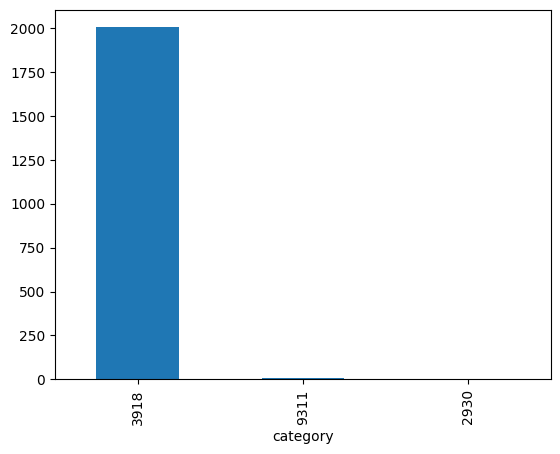

In [93]:
# Visualize result
test_df['category'].value_counts().plot.bar()

In [94]:
test_df['category'].value_counts()

category
3918    2004
9311       9
2930       1
Name: count, dtype: int64

In [95]:
test_df['probability'].value_counts()

probability
0.999986    2014
Name: count, dtype: int64

## Results - images

In [96]:
sample_test = test_df[test_df["category"]=="9311"][:20]
sample_test.head(12)

,filename,category,probability
165,test_Genie_3918_1690521880.png,9311,0.999986
188,test_Genie_3918_1690547878.png,9311,0.999986
586,test_Genie_3918_1690707661.png,9311,0.999986
600,test_Genie_3918_1690708631.png,9311,0.999986
1027,test_Genie_3918_1690853549.png,9311,0.999986
1231,test_Genie_3918_1690904838.png,9311,0.999986
1299,test_Genie_3918_1690930813.png,9311,0.999986
1344,test_Genie_3918_1690941933.png,9311,0.999986
1583,test_Genie_3918_1691022013.png,9311,0.999986


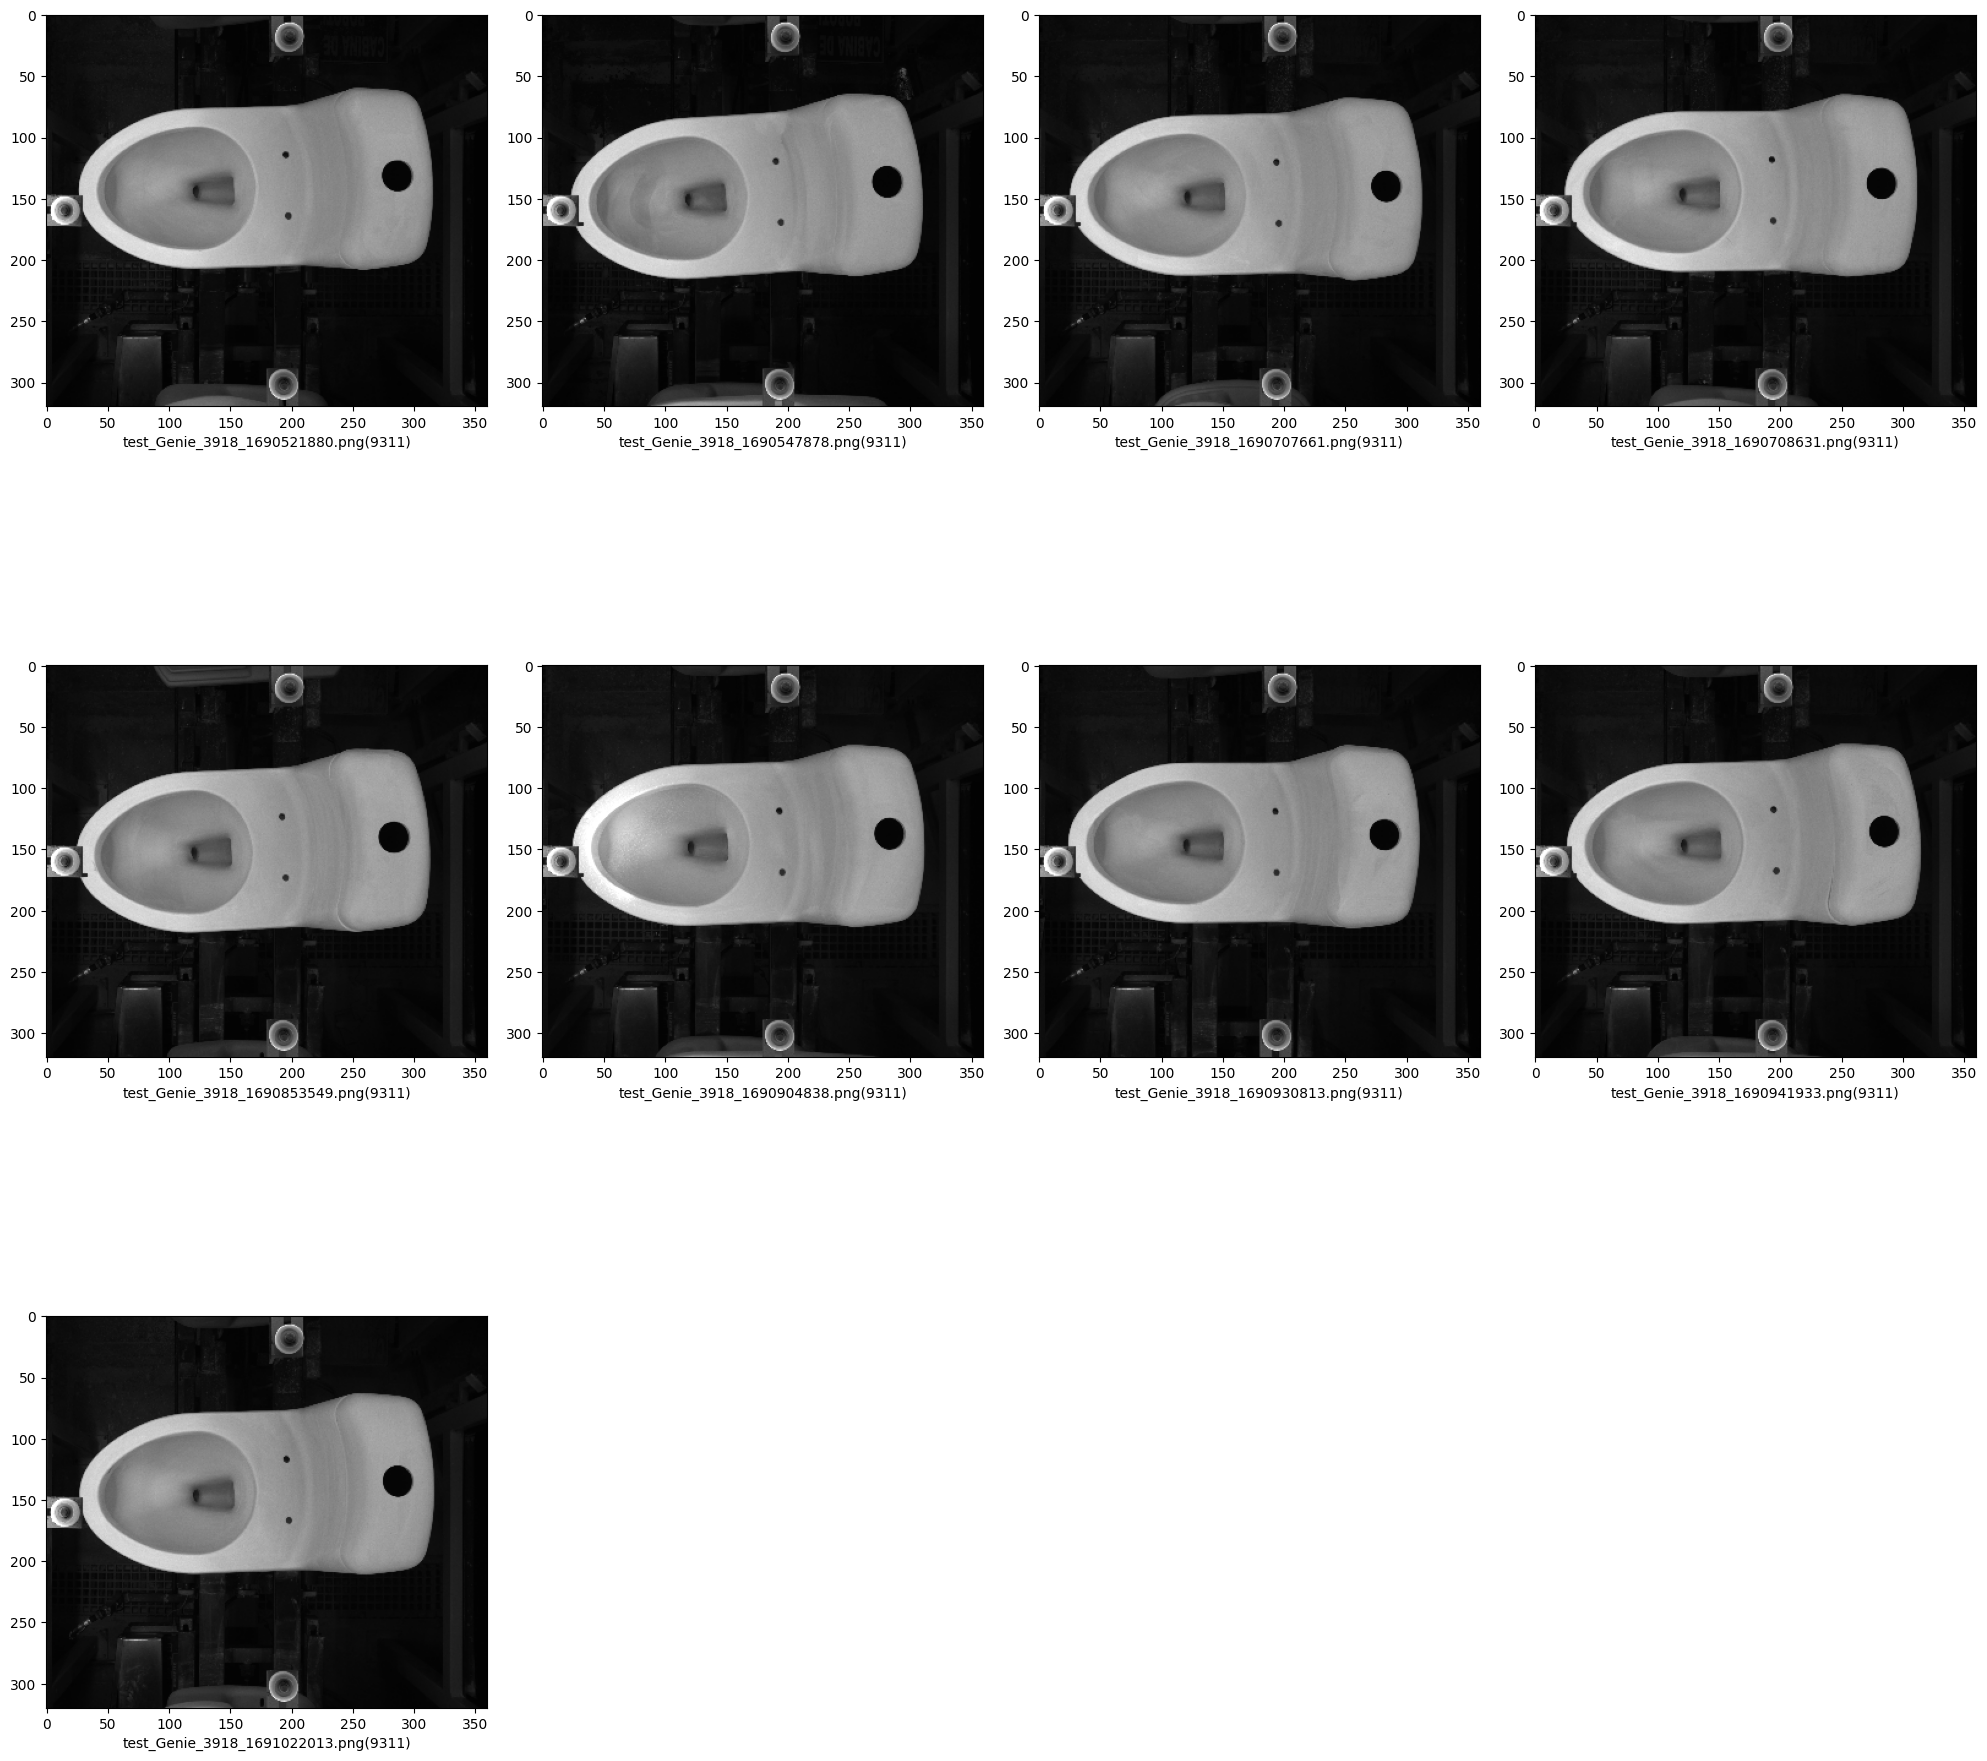

In [97]:
plt.figure(figsize=(20, 20))
for index, (filename, category) in enumerate(zip(sample_test["filename"],sample_test["category"]), start=1):
    img = load_img(error_dir+ "\\" + filename, target_size=IMAGE_SIZE)
    plt.subplot(3, 4, index)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
    
plt.tight_layout()
plt.show()

## Moving results to folder

In [98]:
import shutil
from tqdm import tqdm

In [100]:
for index, row in tqdm(test_df.iterrows(),  total=test_df.shape[0]):
    file_dir = os.path.join(error_dir, row['filename'])
    #print(file_dir)
    shutil.copy(file_dir, os.path.join('D:\\Users\\jmonsalvo\\Desktop\\Test_data_results', row['category']))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2014/2014 [00:05<00:00, 372.95it/s]
